### **Libraries**

In [2]:
import pickle
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_style("white")
import matplotlib.pyplot as plt
import string
from pickle import dump
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import nltk
from nltk.corpus import stopwords
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Sujal\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [3]:
# Load the dataset
dataset = pd.read_csv('dataset/emails.csv')
dataset.shape

(5728, 2)

In [4]:
# Show dataset head (first 5 records)
dataset.head() 

,text,spam
0,Subject: naturally irresistible your corporate...,1
1,Subject: the stock trading gunslinger fanny i...,1
2,Subject: unbelievable new homes made easy im ...,1
3,Subject: 4 color printing special request add...,1
4,"Subject: do not have money , get software cds ...",1


In [5]:
# Show dataset info
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5728 entries, 0 to 5727
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    5728 non-null   object
 1   spam    5728 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 89.6+ KB


In [6]:
# Show dataset statistics
dataset.describe()

,spam
count,5728.000000
mean,0.238827
std,0.426404
min,0.000000
25%,0.000000
50%,0.000000
75%,0.000000
max,1.000000


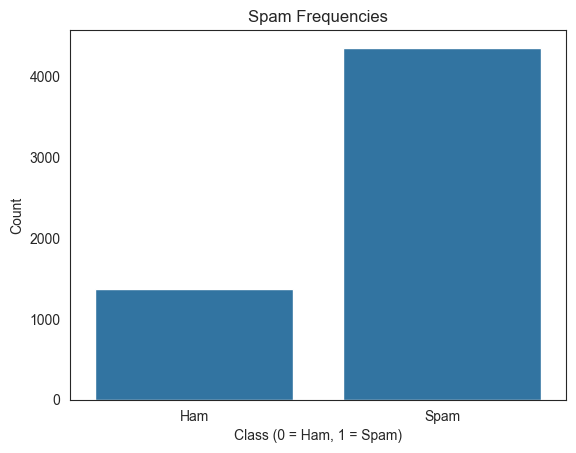

In [7]:
plt.figure(dpi=100)
sns.countplot(data=dataset, x=dataset['spam'].astype(str))  
plt.title("Spam Frequencies")
plt.xlabel("Class (0 = Ham, 1 = Spam)")
plt.ylabel("Count")
plt.xticks(ticks=[0, 1], labels=["Ham", "Spam"])  
plt.show()


In [8]:
# Check for missing data for each column 
dataset.isnull().sum()

text    0
spam    0
dtype: int64

In [9]:
# Check for duplicates and remove them 
dataset.drop_duplicates(inplace=True)

In [10]:
# Cleaning data from punctuation and stopwords and then tokenizing it into words (tokens)
def process(text):
    nopunc = [char for char in text if char not in string.punctuation]
    nopunc = ''.join(nopunc)
    clean = [word for word in nopunc.split() if word.lower() not in stopwords.words('english')]
    return clean

In [11]:
from sklearn.feature_extraction.text import CountVectorizer


vectorizer = CountVectorizer(analyzer='word') 

# Fit and transform the 'text' column
message = vectorizer.fit_transform(dataset['text'])

# Print the shape of the transformed data
print("Shape of transformed data:", message.shape)


Shape of transformed data: (5695, 37303)


In [13]:
import pickle

# Ensure the directory exists
import os
os.makedirs("models", exist_ok=True)

# Save the vectorizer
with open("models/vectorizer.pkl", "wb") as f:
    pickle.dump(message, f)

print("Vectorizer saved successfully!")


Vectorizer saved successfully!


In [14]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(message, dataset['spam'], test_size=0.20, random_state=0)

In [32]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import numpy as np

# Define a maximum sequence length
MAX_LENGTH = 100  # Adjust based on dataset

# Initialize Tokenizer and fit on text data
tokenizer = Tokenizer()
tokenizer.fit_on_texts(dataset['text'])  # dataset['text'] is the column containing messages

# Convert text data into sequences of integers
X_sequences = tokenizer.texts_to_sequences(dataset['text'])

# Pad sequences to ensure uniform shape
X_padded = pad_sequences(X_sequences, maxlen=MAX_LENGTH, padding='post')

# Convert labels to numpy array
y = np.array(dataset['spam'])  # Assuming 'spam' is the target column

# Train-test split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_padded, y, test_size=0.2, random_state=42)
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense

# Define LSTM model
model = Sequential([
    Embedding(input_dim=len(tokenizer.word_index) + 1, output_dim=128, input_length=MAX_LENGTH),
    LSTM(64, return_sequences=True),
    LSTM(32),
    Dense(1, activation='sigmoid')  # Binary classification (Spam/Ham)
])

# Compile model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train model
model.fit(X_train, y_train, epochs=2, batch_size=32, validation_data=(X_test, y_test))




Epoch 1/2
143/143 [==============================] - 29s 179ms/step - loss: 0.3391 - accuracy: 0.8672 - val_loss: 0.2805 - val_accuracy: 0.9157
Epoch 2/2
143/143 [==============================] - 26s 181ms/step - loss: 0.1748 - accuracy: 0.9532 - val_loss: 0.1988 - val_accuracy: 0.9385


In [33]:
# Model saving
dump(model, open("models/model.pkl", 'wb'))

In [34]:

y_pred = model.predict(X_test)  # Predict on test data
print(y_pred)
y_pred_binary = (y_pred > 0.5).astype(int)  # Threshold at 0.5

# Now compute accuracy
print("Accuracy:", accuracy_score(y_test, y_pred_binary))
print(classification_report(y_test, y_pred_binary))


36/36 [==============================] - 2s 26ms/step
[[0.02899385]
 [0.09850162]
 [0.02854096]
 ...
 [0.02837449]
 [0.9712745 ]
 [0.9725944 ]]
Accuracy: 0.9385425812115891
              precision    recall  f1-score   support

           0       0.93      0.99      0.96       843
           1       0.95      0.80      0.87       296

    accuracy                           0.94      1139
   macro avg       0.94      0.89      0.92      1139
weighted avg       0.94      0.94      0.94      1139



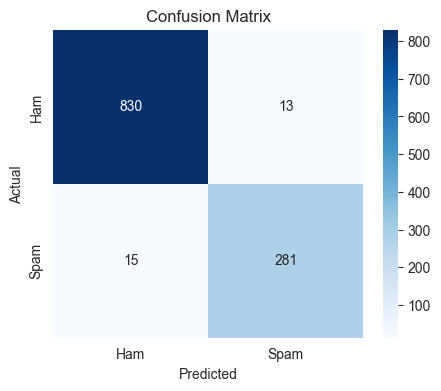

In [28]:

# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred_binary)

# Plot confusion matrix
plt.figure(figsize=(5,4), dpi=100)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Ham", "Spam"], yticklabels=["Ham", "Spam"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()



True Negatives (TN = 830) → Correctly classified ham (non-spam) messages.
False Positives (FP = 13) → Ham messages wrongly classified as spam.
False Negatives (FN = 15) → Spam messages wrongly classified as ham.
True Positives (TP = 281) → Correctly classified spam messages.